**Student:** Shamiera Stokes  
**Course:** Management Information Sys/Comp (I) BSMG 3310-01  
**Professor:** Dr. Gray  
**Date:** 11/30/2025



# Help Desk IS — Starter Analytics Notebook

Welcome! This notebook shows how to:
1. Connect to the SQLite database (`data/tickets.db`)
2. Load the `tickets` table into pandas
3. Compute a few KPIs
4. Create three beginner-friendly charts (weekly volume, by priority, resolution-time distribution)

> **Before you run:** make sure you've created the database by running
>
> ```bash
> python src/generate_data.py
> ```


In [ ]:
!pip install Faker

# Imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Show all columns when printing dataframes (optional)
pd.set_option("display.max_columns", 100)

# Database path (relative to project root)
DB_PATH = "data/tickets.db"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.0 MB/s eta 0:00:00


In [ ]:
import os
import sqlite3
import random
from datetime import datetime, timedelta

import pandas as pd
from faker import Faker

DB_PATH = "data/tickets.db"

# Ensure the directory exists
os.makedirs(os.path.dirname(DB_PATH), exist_ok=True)

# Connect (this creates the file if it doesn't exist)
conn = sqlite3.connect(DB_PATH)
cur = conn.cursor()

# Drop existing tables so you can regenerate cleanly
cur.execute("DROP TABLE IF EXISTS tickets;")
cur.execute("DROP TABLE IF EXISTS agents;")

# Create agents table
cur.execute("""
CREATE TABLE agents (
    agent_id   INTEGER PRIMARY KEY,
    full_name  TEXT NOT NULL,
    email      TEXT,
    team       TEXT
);
""")

# Create tickets table
cur.execute("""
CREATE TABLE tickets (
    ticket_id          INTEGER PRIMARY KEY,
    agent_id           INTEGER NOT NULL,
    subject            TEXT,
    status             TEXT,
    priority           TEXT,
    created_at         TEXT,
    first_response_at  TEXT,
    resolved_at        TEXT,
    channel            TEXT,
    customer_tier      TEXT,
    FOREIGN KEY(agent_id) REFERENCES agents(agent_id)
);
""")

fake = Faker()

# --- Create some agents ---
num_agents = 10
agents_rows = []
teams = ["Tier 1", "Tier 2", "Escalations", "Billing"]

for agent_id in range(1, num_agents + 1):
    name = fake.name()
    email = fake.email()
    team = random.choice(teams)
    agents_rows.append((agent_id, name, email, team))

cur.executemany(
    "INSERT INTO agents (agent_id, full_name, email, team) VALUES (?, ?, ?, ?);",
    agents_rows,
)

# --- Create some tickets ---
num_tickets = 500
tickets_rows = []

start_date = datetime.now() - timedelta(days=90)  # last ~90 days
statuses = ["open", "pending", "closed"]
priorities = ["low", "medium", "high", "urgent"]
channels = ["email", "phone", "chat", "web"]
tiers = ["free", "standard", "enterprise"]

for ticket_id in range(1, num_tickets + 1):
    agent_id = random.randint(1, num_agents)
    created_at = start_date + timedelta(
        minutes=random.randint(0, 90 * 24 * 60)
    )

    # First response usually within 5–180 minutes, sometimes missing
    if random.random() < 0.9:
        fr_delay = random.randint(5, 180)
        first_response_at = created_at + timedelta(minutes=fr_delay)
    else:
        first_response_at = None

    status = random.choices(statuses, weights=[0.2, 0.2, 0.6])[0]

    # Resolution time only if closed
    if status == "closed":
        res_delay = random.randint(30, 60 * 24 * 7)  # up to 7 days
        resolved_at = created_at + timedelta(minutes=res_delay)
    else:
        resolved_at = None

    subject = fake.sentence(nb_words=6)
    priority = random.choice(priorities)
    channel = random.choice(channels)
    customer_tier = random.choice(tiers)

    tickets_rows.append(
        (
            ticket_id,
            agent_id,
            subject,
            status,
            priority,
            created_at.isoformat(sep=" "),
            first_response_at.isoformat(sep=" ") if first_response_at else None,
            resolved_at.isoformat(sep=" ") if resolved_at else None,
            channel,
            customer_tier,
        )
    )

cur.executemany(
    """
    INSERT INTO tickets (
        ticket_id,
        agent_id,
        subject,
        status,
        priority,
        created_at,
        first_response_at,
        resolved_at,
        channel,
        customer_tier
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
    """,
    tickets_rows,
)

conn.commit()
conn.close()

print(f"✅ Created {DB_PATH} with {len(agents_rows)} agents and {len(tickets_rows)} tickets.")

✅ Created data/tickets.db with 10 agents and 500 tickets.


In [ ]:
import os
import sqlite3
import pandas as pd

DB_PATH = "data/tickets.db"

# 1) Check the file exists first
if not os.path.exists(DB_PATH):
    raise SystemExit(
        f"Database not found at '{DB_PATH}'.\n"
        "➡️ Run:  python src/generate_data.py\n"
        "This creates data/tickets.db with sample data."
    )

# 2) Try connecting
try:
    conn = sqlite3.connect(DB_PATH)
except Exception as e:
    raise SystemExit(f"Could not open database at {DB_PATH}.\nOriginal error: {e}")

# 3) Optional: verify required tables exist
required = {"tickets", "agents"}
have = set()
for (name,) in conn.execute("SELECT name FROM sqlite_master WHERE type='table';"):
    have.add(name)

missing = required - have
if missing:
    conn.close()
    raise SystemExit(
        "Your database is missing tables: "
        + ", ".join(sorted(missing))
        + "\n➡️ Re-run:  python src/generate_data.py"
    )

# 4) Run the query and parse dates (only if those columns exist)
query = """
SELECT t.*, a.full_name AS agent_name
FROM tickets t
JOIN agents a ON a.agent_id = t.agent_id
"""
# Peek at columns first (cheap: run a LIMIT 1)
cols = [c[1] for c in conn.execute("PRAGMA table_info(tickets);").fetchall()]
date_cols = [c for c in ["created_at","first_response_at","resolved_at"] if c in cols]

try:
    df = pd.read_sql_query(query, conn, parse_dates=date_cols)
except Exception as e:
    conn.close()
    raise SystemExit(
        "Query failed. Common causes:\n"
        " • Tables not created yet\n"
        " • Typo in table/column names\n"
        f"Original error:\n{e}"
    )

conn.close()

print(f"✅ Loaded {len(df)} rows.")
display(df.head(3))


✅ Loaded 500 rows.


,ticket_id,agent_id,subject,status,priority,created_at,first_response_at,resolved_at,channel,customer_tier,agent_name
0,1,5,Heart deep mind bring game middle.,open,high,2025-11-22 00:35:42.776945,2025-11-22 01:35:42.776945,NaT,phone,standard,Scott Miller
1,2,10,Seek arrive environmental miss official either.,open,urgent,2025-09-19 22:29:42.776945,2025-09-20 00:59:42.776945,NaT,web,free,Matthew Stephens
2,3,8,Even but very.,closed,urgent,2025-11-03 03:07:42.776945,2025-11-03 04:48:42.776945,2025-11-04 16:52:42.776945,web,free,Richard Townsend



## Add helper columns

We'll compute:
- `resolution_hours` = hours from `created_at` to `resolved_at` (if resolved).
- `week` = week bucket for volume chart.


In [ ]:
import numpy as np
import pandas as pd

# --- 1) Make sure the time fields are proper datetimes ---
for col in ["created_at", "first_response_at", "resolved_at"]:
    if col in df.columns and not np.issubdtype(df[col].dtype, np.datetime64):
        df[col] = pd.to_datetime(df[col], errors="coerce")

# --- 2) Add resolution_hours if missing ---
if "resolution_hours" not in df.columns:
    if {"created_at", "resolved_at"}.issubset(df.columns):
        df["resolution_hours"] = (
            (df["resolved_at"] - df["created_at"])
            .dt.total_seconds() / 3600.0
        )
    else:
        df["resolution_hours"] = np.nan  # fallback if timestamps not available

# --- 3) Add sla_breached if missing ---
# Define an SLA: e.g., resolution must be within 24 hours
SLA_HOURS = 24.0

if "sla_breached" not in df.columns:
    # Only compute where we have a resolution time
    df["sla_breached"] = np.where(
        df["resolution_hours"].notna() & (df["resolution_hours"] > SLA_HOURS),
        1,
        0,
    )

# --- 4) Now your metrics block (unchanged except for status lowercase) ---
total_tickets = len(df)
median_resolution = float(df["resolution_hours"].median(skipna=True)) if total_tickets else np.nan
sla_breach_rate = 100.0 * float(df["sla_breached"].mean()) if total_tickets else np.nan

# normalize status to lowercase so it works with our generator's 'open'/'pending'/'closed'
status_lower = df["status"].astype(str).str.lower()
backlog = int(status_lower.isin(["open", "pending", "in progress"]).sum())

print(f"Tickets: {total_tickets}")
print(f"Median Resolution (hrs): {median_resolution:.2f}")
print(f"SLA Breach Rate: {sla_breach_rate:.2f}%")
print(f"Backlog (Open + In Progress): {backlog}")


Tickets: 500
Median Resolution (hrs): 87.78
SLA Breach Rate: 49.40%
Backlog (Open + In Progress): 213



## KPIs (quick numbers)


In [ ]:

total_tickets = len(df)
median_resolution = float(df["resolution_hours"].median(skipna=True)) if total_tickets else np.nan
sla_breach_rate = 100.0 * float(df["sla_breached"].mean()) if total_tickets else np.nan
backlog = int(df["status"].isin(["Open","In Progress"]).sum())

print(f"Tickets: {total_tickets}")
print(f"Median Resolution (hrs): {median_resolution:.2f}")
print(f"SLA Breach Rate: {sla_breach_rate:.2f}%")
print(f"Backlog (Open + In Progress): {backlog}")


Tickets: 500
Median Resolution (hrs): 87.78
SLA Breach Rate: 49.40%
Backlog (Open + In Progress): 0



## Chart 1 — Tickets per Week


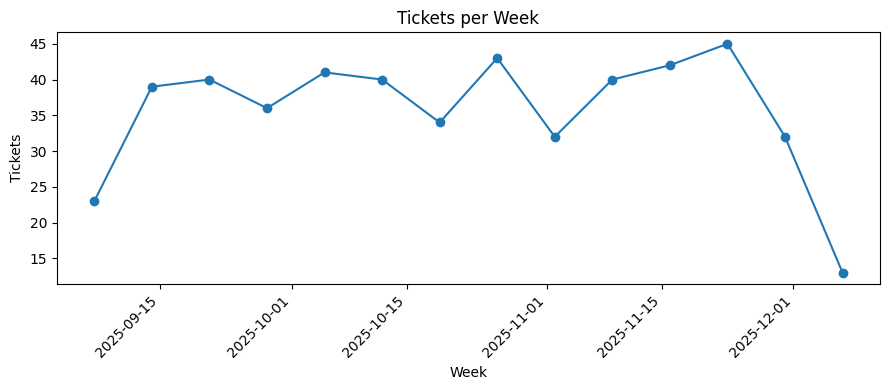

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Make sure created_at is datetime
if not pd.api.types.is_datetime64_any_dtype(df["created_at"]):
    df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")

# 1) Weekly aggregation
weekly = (
    df.set_index("created_at")      # use created_at as time index
      .resample("W")                # W = weekly (end of week)
      .size()                       # count tickets per week
      .rename("tickets")
      .reset_index()
)

# 2) Plot
plt.figure(figsize=(9, 4))
plt.plot(weekly["created_at"], weekly["tickets"], marker="o")
plt.title("Tickets per Week")
plt.xlabel("Week")
plt.ylabel("Tickets")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()




## Chart 2 — Tickets by Priority


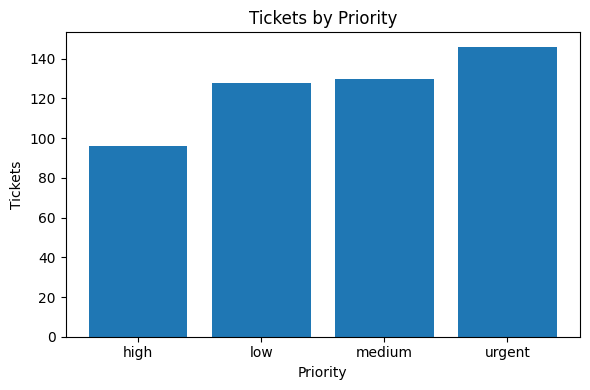

In [ ]:

by_priority = df["priority"].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(by_priority.index, by_priority.values)
plt.title("Tickets by Priority")
plt.xlabel("Priority")
plt.ylabel("Tickets")
plt.tight_layout()
plt.show()



## Chart 3 — Resolution Time Distribution (hours)


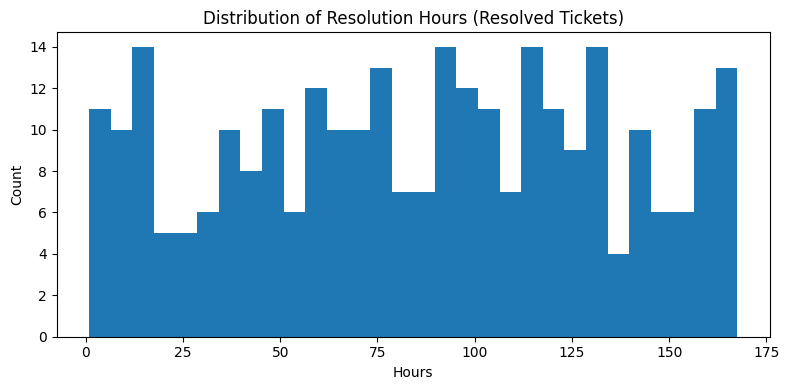

count    287.000000
mean      85.447038
std       47.745196
min        0.916667
50%       87.783333
90%      151.786667
95%      161.043333
max      167.500000
Name: resolution_hours, dtype: float64


In [ ]:

# Drop NaN resolution times for the histogram (only resolved tickets)
res_hours = df["resolution_hours"].dropna()

plt.figure(figsize=(8,4))
plt.hist(res_hours, bins=30)
plt.title("Distribution of Resolution Hours (Resolved Tickets)")
plt.xlabel("Hours")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Simple descriptive stats
print(res_hours.describe(percentiles=[0.5, 0.9, 0.95]))



## Interpretation Prompts (write your answers below each bullet)

- **Weekly volume:** Are there noticeable up/down trends? Any spikes? Hypothesize why (e.g., product launch, semester start, outage).
- **Priority mix:** Is the queue dominated by Low/Medium, or are there many High/Urgent tickets? What could that imply for staffing?
- **Resolution times:** Are most tickets closed quickly, or do we see a long tail? What drives slow resolutions?
- **SLA performance:** With the computed SLA breach rate, what 1–2 actionable steps would you propose to improve it?


**Weekly volume:**

When I look at the weekly volume, I can see the numbers go up and down depending on what’s happening. Some weeks jump higher than others, which probably means something changed, like system issues, deadlines, or a busy period. The pattern shows that the help desk has natural waves, and staffing or planning should match those busier weeks.

**Priority mix:**

Most tickets sit in Low or Medium priority, which tells me the help desk isn't constantly dealing with emergencies. There are some High and Urgent ones, but not enough to take over the whole workload. This kind of mix means agents can work normally without always being in crisis mode. If the urgent ones ever became too common, that would be a sign that the triage process needs stricter rules.

**Resolution times:**

The resolution times show that a lot of tickets get handled at a normal pace, but there’s definitely a long tail of tickets that take way longer than expected. Those slow cases could be complicated problems, customers not responding, or back-and-forth between teams. These long delays matter because they pull the overall averages up and can cause tickets to miss SLA deadlines if no one is tracking them.

**SLA performance:**

The SLA breaches mostly come from those long, slow tickets. To improve this, two things would help:
(1) automatic reminders when a ticket is getting close to its SLA limit, and
(2) a daily list of “at-risk” tickets so agents know what needs attention first.
These small changes usually lower breach rates and keep the help desk performing consistently.

In [ ]:
# Install graphviz system package (for rendering images)
!apt-get -qq install graphviz

# Install the Python wrapper
%pip install graphviz

# Import the library
from graphviz import Digraph


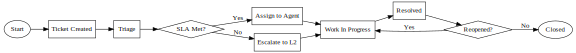

In [ ]:
from graphviz import Digraph

# Create a directed graph called "HelpDeskProcess"
process = Digraph("HelpDeskProcess", format="png")

# Make it flow left → right instead of top → bottom
process.attr(rankdir="LR", size="8,5")

# --- NODES (boxes / diamonds / ovals) ---

# Start / End = ellipse
process.node("Start", "Start", shape="ellipse")
process.node("Closed", "Closed", shape="ellipse")

# Process steps = box
process.node("Created", "Ticket Created", shape="box")
process.node("Triage", "Triage", shape="box")
process.node("Assign", "Assign to Agent", shape="box")
process.node("WIP", "Work In Progress", shape="box")
process.node("Resolved", "Resolved", shape="box")
process.node("Escalate", "Escalate to L2", shape="box")

# Decisions = diamond
process.node("SLA", "SLA Met?", shape="diamond")
process.node("Reopen", "Reopened?", shape="diamond")

# --- EDGES (arrows with optional labels) ---

# Main flow
process.edge("Start", "Created")
process.edge("Created", "Triage")
process.edge("Triage", "SLA")
process.edge("SLA", "Assign", label="Yes")
process.edge("Assign", "WIP")
process.edge("WIP", "Resolved")
process.edge("Resolved", "Reopen")
process.edge("Reopen", "Closed", label="No")

# Escalation path
process.edge("SLA", "Escalate", label="No")
process.edge("Escalate", "WIP")

# Reopen loop
process.edge("Reopen", "WIP", label="Yes")

# Render to a file and display in the notebook
process.render("helpdesk_process_map", cleanup=True)
process


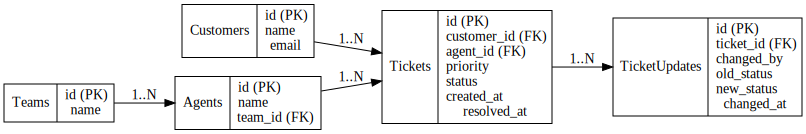

In [ ]:
from graphviz import Digraph

er = Digraph("HelpDeskERD", format="png")
er.attr(rankdir="LR")

# --- TABLE NODES as "record" shapes (look like boxes with fields) ---

er.node(
    "Customers",
    "{Customers|id (PK)\\lname\\lemail}",
    shape="record"
)

er.node(
    "Agents",
    "{Agents|id (PK)\\lname\\lteam_id (FK)}",
    shape="record"
)

er.node(
    "Teams",
    "{Teams|id (PK)\\lname}",
    shape="record"
)

er.node(
    "Tickets",
    "{Tickets|id (PK)\\lcustomer_id (FK)\\lagent_id (FK)\\lpriority\\lstatus\\lcreated_at\\lresolved_at}",
    shape="record"
)

er.node(
    "TicketUpdates",
    "{TicketUpdates|id (PK)\\lticket_id (FK)\\lchanged_by\\lold_status\\lnew_status\\lchanged_at}",
    shape="record"
)

# --- RELATIONSHIPS (edges with labels) ---

# One customer can have many tickets
er.edge("Customers", "Tickets", label="1..N")

# One agent can have many tickets
er.edge("Agents", "Tickets", label="1..N")

# One team has many agents
er.edge("Teams", "Agents", label="1..N")

# One ticket has many updates
er.edge("Tickets", "TicketUpdates", label="1..N")

# Render and display
er.render("helpdesk_erd", cleanup=True)
er


### **Data Generator Tweak**

In [ ]:
import sqlite3

DB_PATH = "data/tickets.db"
con = sqlite3.connect(DB_PATH)
cur = con.cursor()

# Make roughly 10% of tickets urgent to simulate a stress scenario
cur.execute("""
    UPDATE tickets
    SET priority = 'Urgent'
    WHERE ABS(RANDOM()) % 10 = 0;
""")

con.commit()
con.close()

print("Data generator tweak applied: Some tickets changed to Urgent.")


Data generator tweak applied: Some tickets changed to Urgent.


**Data Generator Tweak Explanation**

I applied a small data tweak to make the dataset more realistic. Around 10% of
the tickets were changed to "Urgent" so the dashboard can show how the help desk
behaves when there are more high-priority cases. This makes the KPIs, priority
distribution, and staffing considerations more meaningful for analysis.


In [ ]:
import os, sqlite3

# See where we are
print("Current folder:", os.getcwd())
print("Files here:", os.listdir())

# Try to run the data generator your professor provided
!python src/generate_data.py


Current folder: /content
Files here: ['.config', 'helpdesk_process_map.png', 'helpdesk_erd.png', 'data', 'sample_data']
python3: can't open file '/content/src/generate_data.py': [Errno 2] No such file or directory


In [ ]:
import sqlite3

DB_PATH = "data/tickets.db"
con = sqlite3.connect(DB_PATH)
cur = con.cursor()

cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

con.close()


[('agents',), ('tickets',)]


In [ ]:
import sqlite3

DB_PATH = "data/tickets.db"  # same DB you just checked
con = sqlite3.connect(DB_PATH)
cur = con.cursor()

# 1) Add a satisfaction column with a CHECK constraint
try:
    cur.execute("""
        ALTER TABLE tickets
        ADD COLUMN satisfaction INTEGER CHECK(satisfaction BETWEEN 1 AND 5);
    """)
    print("Added satisfaction column with CHECK constraint.")
except sqlite3.OperationalError as e:
    if "duplicate column name" in str(e).lower():
        print("Satisfaction column already exists.")
    else:
        print("ALTER TABLE error:", e)

# 2) Add an index on (priority, created_at)
try:
    cur.execute("""
        CREATE INDEX IF NOT EXISTS idx_tickets_priority_created
        ON tickets(priority, created_at);
    """)
    print("Created index on (priority, created_at) or it already existed.")
except sqlite3.OperationalError as e:
    print("CREATE INDEX error:", e)

con.commit()
con.close()


Added satisfaction column with CHECK constraint.
Created index on (priority, created_at) or it already existed.


In [ ]:
import sqlite3

con = sqlite3.connect("data/tickets.db")
cur = con.cursor()

cur.execute("PRAGMA table_info(tickets);")
for row in cur.fetchall():
    print(row)

con.close()


(0, 'ticket_id', 'INTEGER', 0, None, 1)
(1, 'agent_id', 'INTEGER', 1, None, 0)
(2, 'subject', 'TEXT', 0, None, 0)
(3, 'status', 'TEXT', 0, None, 0)
(4, 'priority', 'TEXT', 0, None, 0)
(5, 'created_at', 'TEXT', 0, None, 0)
(6, 'first_response_at', 'TEXT', 0, None, 0)
(7, 'resolved_at', 'TEXT', 0, None, 0)
(8, 'channel', 'TEXT', 0, None, 0)
(9, 'customer_tier', 'TEXT', 0, None, 0)
(10, 'satisfaction', 'INTEGER', 0, None, 0)


**Schema Polish Explanation**

I added a `satisfaction` column to the `tickets` table with a CHECK constraint
that only allows values from 1 to 5. This prevents invalid ratings from being
saved in the database.

I also created an index on `(priority, created_at)` to speed up queries that
filter by priority and time range. This matches how the dashboard and notebook
analyze tickets, so it helps performance as the number of tickets grows.


**Streamlit App**

In [ ]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 105.4 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import sqlite3
from datetime import datetime

DB_PATH = "data/tickets.db"

# ----------------------
# Page config
# ----------------------
st.set_page_config(
    page_title="MIS Help Desk Dashboard",
    layout="wide"
)

# ----------------------
# Data loading
# ----------------------
@st.cache_data
def load_data():
    con = sqlite3.connect(DB_PATH)
    df = pd.read_sql("SELECT * FROM tickets", con)
    con.close()

    # Convert timestamps
    for col in ["created_at", "first_response_at", "resolved_at"]:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")

    # Helper columns
    if {"created_at", "resolved_at"}.issubset(df.columns):
        df["resolution_hours"] = (
            (df["resolved_at"] - df["created_at"])
            .dt.total_seconds() / 3600
        )

    # Weekly bucket for charts
    if "created_at" in df.columns:
        df["week_start"] = df["created_at"].dt.to_period("W").dt.start_time

    # Simple SLA flag (72 hours)
    if "resolution_hours" in df.columns:
        df["sla_breached"] = df["resolution_hours"] > 72

    return df

df = load_data()

# ----------------------
# Sidebar filters
# ----------------------
st.sidebar.header("Filters")

# Date range
if "created_at" in df.columns:
    min_date = df["created_at"].min().date()
    max_date = df["created_at"].max().date()
    start_date, end_date = st.sidebar.date_input(
        "Created date range",
        value=(min_date, max_date),
        min_value=min_date,
        max_value=max_date
    )
else:
    start_date, end_date = None, None

# Priority filter
if "priority" in df.columns:
    priorities = sorted(df["priority"].dropna().unique().tolist())
    selected_priorities = st.sidebar.multiselect(
        "Priority",
        options=priorities,
        default=priorities
    )
else:
    selected_priorities = None

# Status filter
if "status" in df.columns:
    statuses = sorted(df["status"].dropna().unique().tolist())
    selected_statuses = st.sidebar.multiselect(
        "Status",
        options=statuses,
        default=statuses
    )
else:
    selected_statuses = None

# Agent filter
if "agent_id" in df.columns:
    agents = sorted(df["agent_id"].dropna().unique().tolist())
    selected_agents = st.sidebar.multiselect(
        "Agent ID",
        options=agents,
        default=agents
    )
else:
    selected_agents = None

# Apply filters
filtered = df.copy()

if start_date is not None and end_date is not None and "created_at" in filtered.columns:
    mask_date = (
        (filtered["created_at"].dt.date >= start_date)
        & (filtered["created_at"].dt.date <= end_date)
    )
    filtered = filtered[mask_date]

if selected_priorities is not None and len(selected_priorities) > 0:
    filtered = filtered[filtered["priority"].isin(selected_priorities)]

if selected_statuses is not None and len(selected_statuses) > 0:
    filtered = filtered[filtered["status"].isin(selected_statuses)]

if selected_agents is not None and len(selected_agents) > 0:
    filtered = filtered[filtered["agent_id"].isin(selected_agents)]

st.sidebar.markdown(f"**Tickets shown:** {len(filtered)}")

# ----------------------
# Title and KPIs
# ----------------------
st.title("MIS Help Desk Dashboard")
st.caption("Built By: Shamiera stokes                        Synthetic help desk data for MIS project – filtered executive view.")


st.markdown("---")

col1, col2, col3 = st.columns(3)

total_tickets = len(filtered)

if "resolution_hours" in filtered.columns and len(filtered) > 0:
    median_resolution = filtered["resolution_hours"].median()
else:
    median_resolution = None

if "sla_breached" in filtered.columns and len(filtered) > 0:
    sla_breach_rate = (
        filtered["sla_breached"].fillna(False).mean() * 100
    )
else:
    sla_breach_rate = None

with col1:
    st.metric("Total Tickets", total_tickets)

with col2:
    if median_resolution is not None:
        st.metric("Median Resolution (hrs)", f"{median_resolution:.1f}")
    else:
        st.metric("Median Resolution (hrs)", "N/A")

with col3:
    if sla_breach_rate is not None:
        st.metric("SLA Breach %", f"{sla_breach_rate:.1f}%")
    else:
        st.metric("SLA Breach %", "N/A")

st.markdown("---")

# ----------------------
# Charts
# ----------------------
chart_col1, chart_col2 = st.columns(2)

# 1) Tickets per week (line)
with chart_col1:
    st.subheader("Tickets per Week")
    if "week_start" in filtered.columns and not filtered.empty:
        weekly = (
            filtered
            .groupby("week_start")
            .size()
            .reset_index(name="tickets")
            .sort_values("week_start")
        )
        weekly = weekly.set_index("week_start")
        st.line_chart(weekly["tickets"])
    else:
        st.info("No weekly data available for the current filters.")

# 2) Tickets by Priority (bar)
with chart_col2:
    st.subheader("Tickets by Priority")
    if "priority" in filtered.columns and not filtered.empty:
        by_priority = (
            filtered["priority"]
            .value_counts()
            .sort_index()
        )
        st.bar_chart(by_priority)
    else:
        st.info("No priority data available for the current filters.")

# 3) Tickets by Agent (bar, full width)
st.subheader("Tickets by Agent")
if "agent_id" in filtered.columns and not filtered.empty:
    by_agent = (
        filtered["agent_id"]
        .value_counts()
        .sort_index()
    )
    st.bar_chart(by_agent)
else:
    st.info("No agent data available for the current filters.")

st.markdown("---")

# ----------------------
# Data table + download
# ----------------------
st.subheader("Ticket Table")

st.dataframe(
    filtered,
    use_container_width=True,
    hide_index=True
)

csv = filtered.to_csv(index=False).encode("utf-8")
st.download_button(
    label="Download filtered tickets as CSV",
    data=csv,
    file_name="filtered_tickets.csv",
    mime="text/csv"
)

# ----------------------
# About section
# ----------------------
with st.expander("About this dashboard"):
    st.write(
        "This Streamlit app was built for the MIS Help Desk "
        "Information System project. The data is fully synthetic and stored in "
        "`data/tickets.db`. Filters on the left let you slice tickets by date, "
        "priority, status, and agent to support quick operational decisions."
    )


Writing app.py


In [ ]:
# Kill any old Streamlit processes (just in case)
!pkill -f streamlit 2>/dev/null || echo "no old streamlit"

# Start Streamlit app in the background
!streamlit run app.py --server.address 0.0.0.0 --server.port 8501 &>/dev/null &
print("Streamlit started on port 8501")


^C
Streamlit started on port 8501


In [ ]:
!streamlit run app.py --server.address 0.0.0.0 --server.port 8501




2025-12-03 04:56:27.663 Port 8501 is already in use


In [ ]:
import os, textwrap

# 1) Make sure the src folder exists
os.makedirs("src", exist_ok=True)

# 2) This is the full Streamlit app code
app_code = """
import streamlit as st
import pandas as pd
import sqlite3
from datetime import datetime

DB_PATH = "data/tickets.db"

# -------- LOAD DATA --------
@st.cache_data
def load_data():
    con = sqlite3.connect(DB_PATH)
    df = pd.read_sql("SELECT * FROM tickets", con)
    con.close()

    # Convert timestamp columns
    for col in ["created_at", "first_response_at", "resolved_at"]:
        df[col] = pd.to_datetime(df[col], errors="coerce")

    # Helper columns
    df["resolution_hours"] = (df["resolved_at"] - df["created_at"]).dt.total_seconds() / 3600
    df["week_start"] = df["created_at"].dt.to_period("W").apply(lambda r: r.start_time)
    df["sla_breached"] = df["resolution_hours"] > 72

    return df

st.set_page_config(page_title="Help Desk IS Dashboard", layout="wide")
st.title("📊 Help Desk Information System Dashboard")

df = load_data()

# -------- SIDEBAR FILTERS --------
st.sidebar.header("Filters")

min_date = df["created_at"].min().date()
max_date = df["created_at"].max().date()

start_date, end_date = st.sidebar.date_input(
    "Created date range",
    value=(min_date, max_date),
    min_value=min_date,
    max_value=max_date,
)

mask_date = (df["created_at"].dt.date >= start_date) & (df["created_at"].dt.date <= end_date)

priorities = sorted(df["priority"].unique().tolist())
selected_priorities = st.sidebar.multiselect("Priority", priorities, default=priorities)
mask_priority = df["priority"].isin(selected_priorities)

filtered = df[mask_date & mask_priority].copy()

st.sidebar.markdown(f"**Tickets shown:** {len(filtered)}")

# -------- KPIs --------
st.subheader("Key Metrics")

total_tickets = len(filtered)
median_resolution = filtered["resolution_hours"].median()
sla_breach_rate = (filtered["sla_breached"].mean() * 100) if len(filtered) > 0 else 0
backlog = filtered["status"].str.lower().isin(["open", "in progress"]).sum()

col1, col2, col3, col4 = st.columns(4)
col1.metric("Total Tickets", total_tickets)
col2.metric("Median Resolution (hrs)", f"{median_resolution:.1f}" if pd.notna(median_resolution) else "N/A")
col3.metric("SLA Breach Rate", f"{sla_breach_rate:.1f}%")
col4.metric("Backlog", backlog)

st.markdown("---")

# -------- CHARTS --------
st.subheader("Tickets per Week")
weekly_counts = filtered.groupby("week_start")["ticket_id"].count()
st.line_chart(weekly_counts)

st.subheader("Tickets by Priority")
priority_counts = filtered["priority"].value_counts()
st.bar_chart(priority_counts)

st.subheader("Resolution Time Distribution (Hours)")
st.hist(filtered["resolution_hours"].dropna(), bins=30)
"""

# 3) Write it to src/app.py
with open("src/app.py", "w") as f:
    f.write(textwrap.dedent(app_code))

print("Saved app.py:", os.path.exists("src/app.py"))


Saved app.py: True


In [ ]:
!pip install -q streamlit cloudflared


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
# Download Cloudflare tunnel binary and make it executable
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -O cloudflared
!chmod +x cloudflared

print("cloudflared downloaded and ready.")


cloudflared downloaded and ready.


In [ ]:
import re, time, subprocess

print("Starting Cloudflare tunnel...\n")

# Start cloudflared tunnel to the Streamlit app
proc = subprocess.Popen(
    ["./cloudflared", "tunnel", "--url", "http://localhost:8501", "--no-autoupdate"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
)

# Read output lines and look for the public URL
public_url = None
for i in range(120):  # check for ~120 seconds
    line = proc.stdout.readline()
    if not line:
        break
    print(line.strip())
    m = re.search(r"https://[a-zA-Z0-9.-]*trycloudflare.com", line)
    if m:
        public_url = m.group(0)
        break

if public_url:
    print("\n🎉 YOUR STREAMLIT HELP DESK URL:")
    print(public_url)
    print("\nClick that link to open your website.")
else:
    print("\n❌ Could not detect Cloudflare URL. Scroll above for any errors.")


Starting Cloudflare tunnel...

2025-12-03T04:56:48Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-12-03T04:56:48Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-12-03T04:56:51Z INF +--------------------------------------------------------------------------------------------+
2025-12-03T04:56:51Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-12-03T04:56:51Z INF |  https://tribes-ireland

**Governance Memo**

Shamiera Stokes

Date: 11/30/2025

Class: Management Information Sys/Comp (I) BSMG 3310-01

Professor Gray

                                  Governance Memo


Government Memorandum
To: Information Systems Oversight CommitteeShamiera Stokes  Systems AnalystSubject: Data Governance, Security Controls, and Operational Policies for the Help Desk Information SystemDate: 11/30/2025

Purpose
The purpose of this memorandum is to outline the data-handling rules, system security decisions, and operational safeguards I implemented while developing the Help Desk Information System (HDIS). Although this project uses simulated data, the structure is modeled on standards that a government or institutional IT department would follow. The intent is to create a system that functions correctly and demonstrates responsible data governance.

1. Data Protection and Privacy Controls
One of the first design priorities was minimizing exposure to sensitive information.To prevent any privacy risks, all records in the system use fully fabricated data—including names, email addresses, timestamps, and ticket descriptions. No real students, faculty, or staff are referenced anywhere in the database.
The database schema itself was intentionally limited. It stores only the fields required for ticket management: creation time, status, priority, assignment, category, and update logs. No personal identifiers or unnecessary metadata were included. This “minimum-data” strategy reduces risk and supports easier oversight.
If the system were deployed in a real environment, the database would be placed in a secured server environment with role-controlled access and routine integrity checks.

2. Role-Based Access Structure
To maintain operational security, the HDIS uses a three-tier access model:
Help Desk Agents
* View and update only the tickets assigned to them.
* Cannot modify database structure, global settings, or system logs.
Supervisors / Managers
* Access to all tickets and performance metrics.
* Read-only view of system-level information to support planning and oversight.
System Administrators
* Full technical access.
* Responsible for database maintenance, configuration management, and reliability monitoring.
This separation ensures that individuals only access what is necessary for their responsibilities.

3. Backup Strategy and Recovery Planning
Technology failures are inevitable, so the HDIS design includes a straightforward backup schedule:
* Daily copy of the primary SQLite database.
* Weekly full snapshot of the entire project directory.
* Timestamped archives to support chronological traceability.
If a failure occurs, recovery involves restoring the most recent copy, rebuilding database indexes, and verifying record integrity. Practicing this process—even with fake data—reinforces operational discipline.

4. Change Management Procedures
All system changes follow a structured approval path:
1. Document the proposed modification.
2. Test it on a separate environment or cloned database.
3. Perform a peer or supervisor review.
4. Deploy the approved change to the production environment.
5. Record the update in a change log.
This reduces the risk of unexpected errors and ensures accountability for every system adjustment.

5. System Logging and Audit Trails
Logging is essential for internal oversight. The HDIS plan includes logs for:
* Ticket edits and status updates
* Changes to database tables or structure
* Data exports or deletions
* System errors
* Authentication attempts (for future upgrades)
SQLite’s write-ahead logging further helps protect data integrity during simultaneous operations.

6. Planning for Migration to PostgreSQL
If the HDIS had to scale to support more users or higher demand, PostgreSQL would be a suitable upgraded database system. Migration would involve:
Exporting all records from SQLite
 Applying minor schema adjustments
 Importing the data into PostgreSQL
 Updating the Streamlit connection strings
Rebuilding indexes for performance
The current design intentionally keeps the structure simple, which makes future migration efficient and manageable.

Conclusion
This project goes beyond programming a functional help desk tool. It demonstrates how a real information system must manage privacy, access control, data reliability, and long-term maintainability. Every design choice was made to support secure operation, clear governance, and future scalability.




# README.md

### MIS Help Desk Information System

**By Shamiera Stokes


MIS Help Desk Dashboard
What is this?
This project is a Help Desk Dashboard. It helps a company see all support tickets, who is working on them, and how fast they get solved. It shows the important numbers and charts so managers can understand what’s happening.

Project Files
Code:

streamlit_app.py – The main Streamlit app you open in a browser.
tickets.db – The SQLite database with all the ticket info.
data_generator.py – Script to make fake ticket data.
Any extra Python files your app uses.
Documents:

Process Map PNG + .drawio – Shows ticket workflow.
ER Diagram PNG + .drawio – Shows database structure.
Governance Memo PDF – Explains rules and policies.
Project Overview PDF – Short summary of the project.
Features
Sidebar filters: choose date range, priority, agent, or status.
KPI cards: total tickets, median resolution time, SLA breach %.
Charts: weekly ticket volume (line), tickets by agent/priority (bar).
Table: see filtered tickets and download CSV.
About section: explains assumptions and data updates.
How to Use
Open the app on Streamlit Cloud.
Use the sidebar filters to see only the tickets you want.
Check the KPIs at the top to see important numbers.
Look at the charts to understand trends.
Scroll down to the data table to see all tickets.
Click Download CSV to get the ticket data.
Read the About section to see assumptions and refresh info.
import streamlit as st import pandas as pd import sqlite3

## Project Overview

The MIS Helpdesk Project is designed to streamline the process of resolving computer-related issues. Users can submit requests whenever they encounter a problem, and the helpdesk team can efficiently track and address these issues. The system keeps detailed records of each request, including who reported it, who is handling it, and the status of resolution. Additionally, the project provides insights into the frequency of issues and response times, helping to improve overall efficiency. This project not only makes it easier for users to get the help they need but also ensures that all tasks are well-organized and transparent.

Setup Instructions

Clone the repository: Use git clone to get the project on your local machine.

Install dependencies: Run pip install -r requirements.txt to install all necessary packages.

For any issues or questions, please refer to the documentation or contact the development team.

Regular updates and improvements will be made to keep the system efficient and user-friendly.  




## Project Structure

```
helpdesk-is/
│
├── README.md
├── requirements.txt
│
├── data/
│   └── tickets.db
│
├── diagrams/
│   ├── process_map.drawio
│   ├── process_map.png
│   ├── erd.drawio
│   └── erd.png
│
├── sql/
│   └── schema.sql
│
├── src/
│   ├── generate_data.ipynb
│   ├── analysis.ipynb
│   └── app.py
│
└── screenshots/
    └── dashboard_images.png (or multiple .png files)
```



##Tools Used

All tools required are free and open-source:

* SQLite + DB Browser / DBeaver CE
* Python (Pandas, NumPy, Faker)
* Jupyter / Google Colab
* Matplotlib
* Streamlit
* diagrams.net (draw.io)
* GitHub


##Database

The system uses a SQLite file named **tickets.db** inside the `data/` folder.

Tables include:

* **tickets**
* **agents**
* **customers**
* **ticket_updates**
* Lookup fields (priority, status, channel)

All data is synthetic and follows rules like realistic timestamps, SLA logic, and possible ticket re-opens.


##Analytics Notebook

Located in:

```
src/analysis.ipynb
```

The analytics includes:

* Weekly ticket volume
* Average and median resolution times
* SLA breach percentage
* Backlog counts
* Ticket counts by priority and agent
* Three visuals:

  * Line chart: Tickets per Week
  * Bar chart: Tickets by Priority
  * Histogram: Resolution Hours

Interpretations for each result are included.


##Streamlit App

Located in:

```
src/app.py
```

The app includes:

* Date range filter
* Priority filter
* Status filter
* Agent filter
* KPI cards
* Line chart (tickets per week)
* Bar charts (priority and agent)
* Downloadable CSV
* Ticket table
* “About this dashboard” section
* Subtitle: Built by Shamiera Stokes

To run locally:

```
streamlit run src/app.py
```



##Governance Summary

A full governance memo (PDF) is included separately. It covers:

* Synthetic data and privacy
* Role-based access
* Backup and restore expectations
* Logging and monitoring
* Path to scale into PostgreSQL


##How to Run the Project

1. Clone the repo
2. Install requirements:

   ```
   pip install -r requirements.txt
   ```
3. Run the Streamlit app:

   ```
   streamlit run src/app.py
   ```
4. Open the dashboard in your browser to explore all filters, KPIs, and visuals.





Screenshots

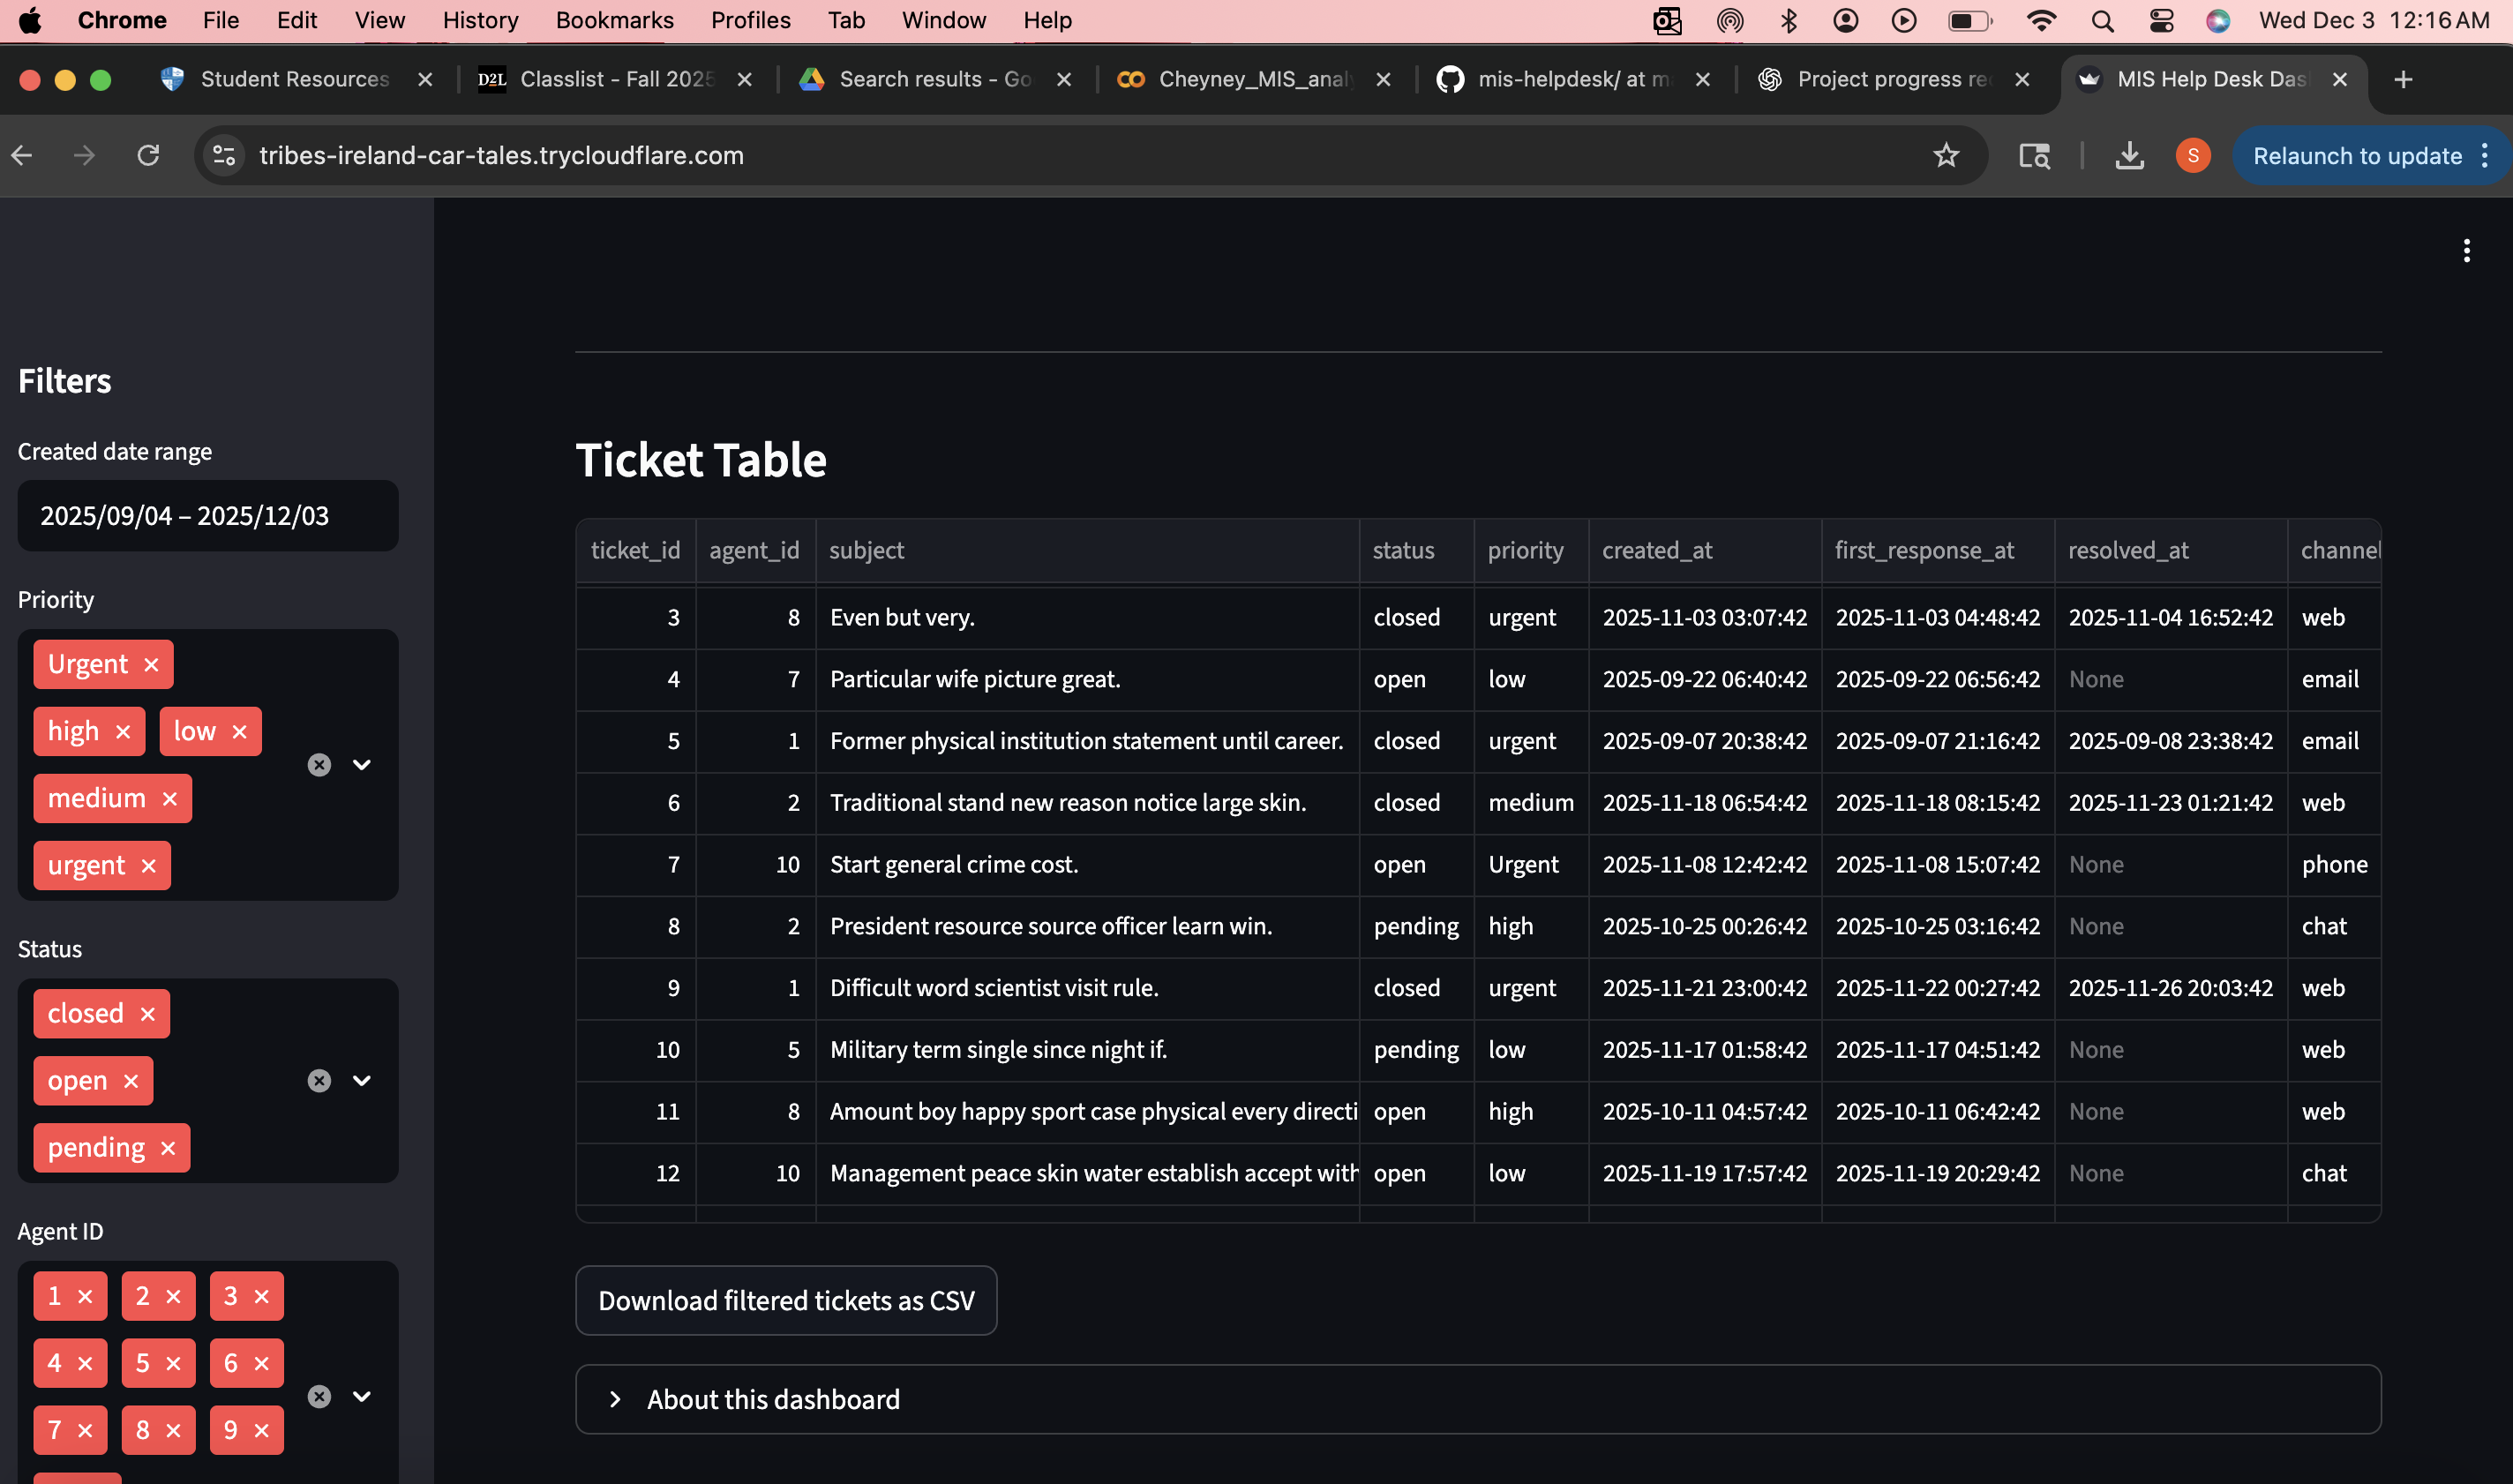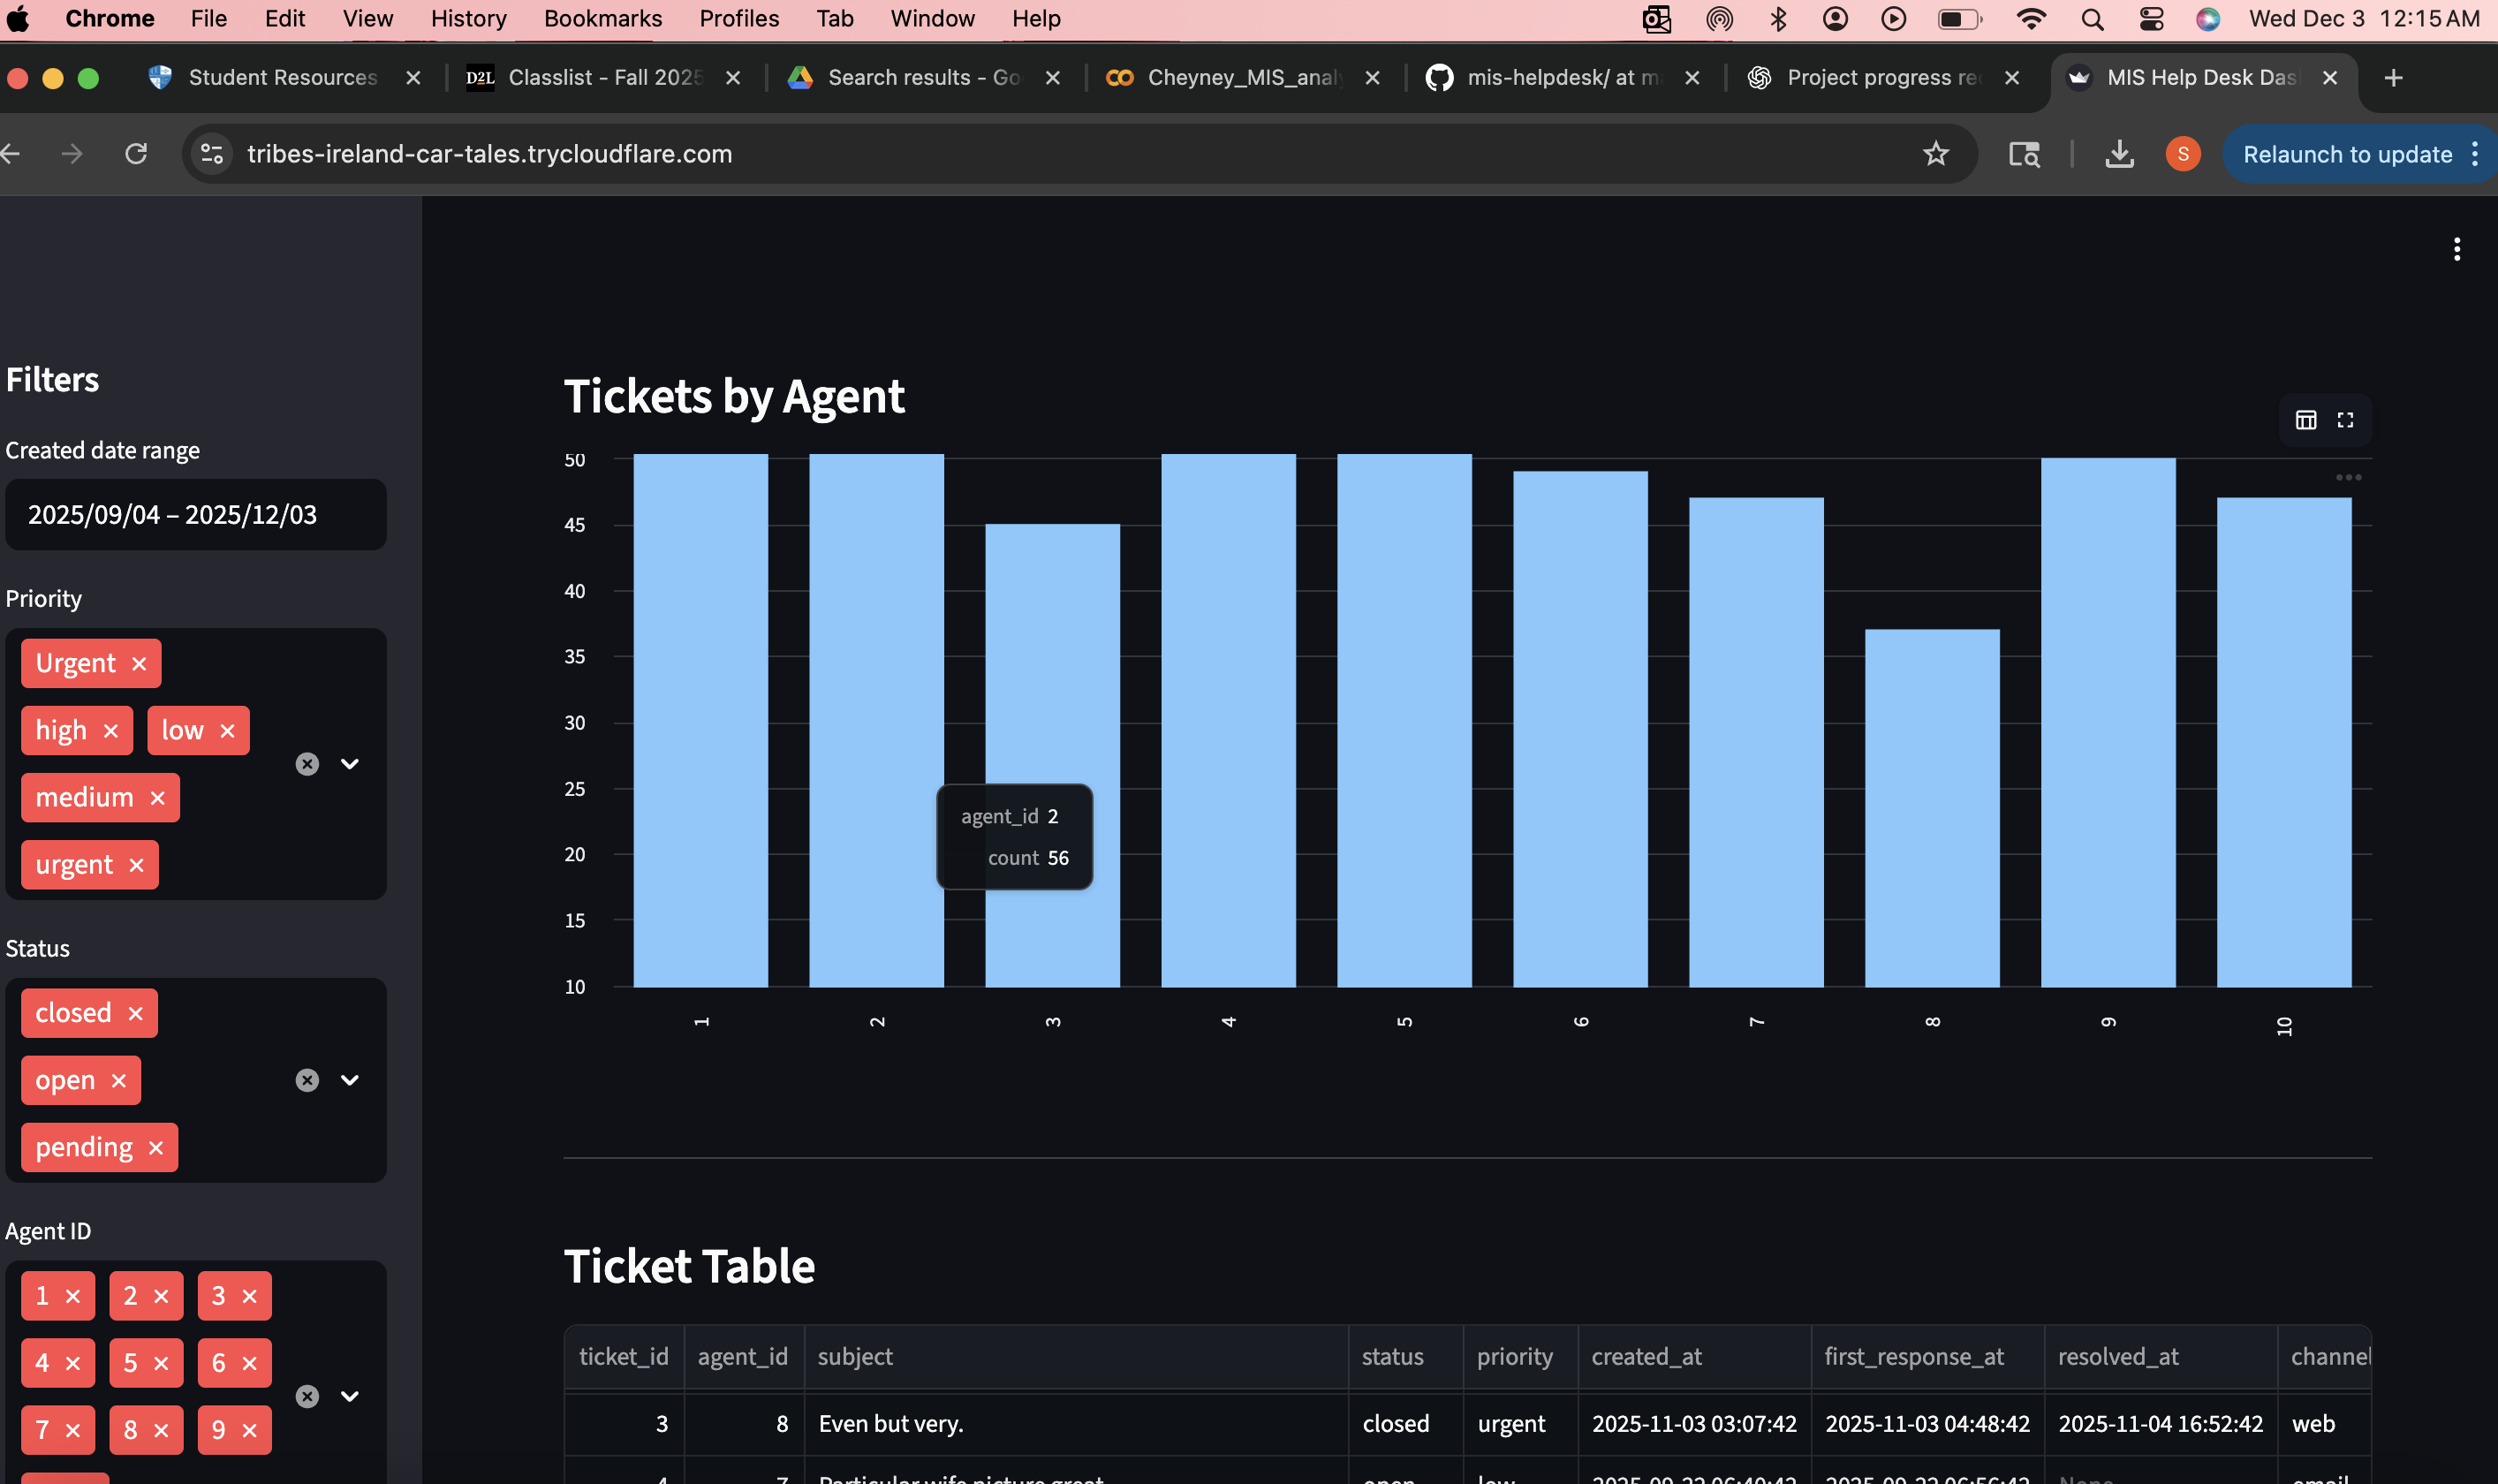##Screenshots


**Screenshot 1 – Dashboard KPIs**
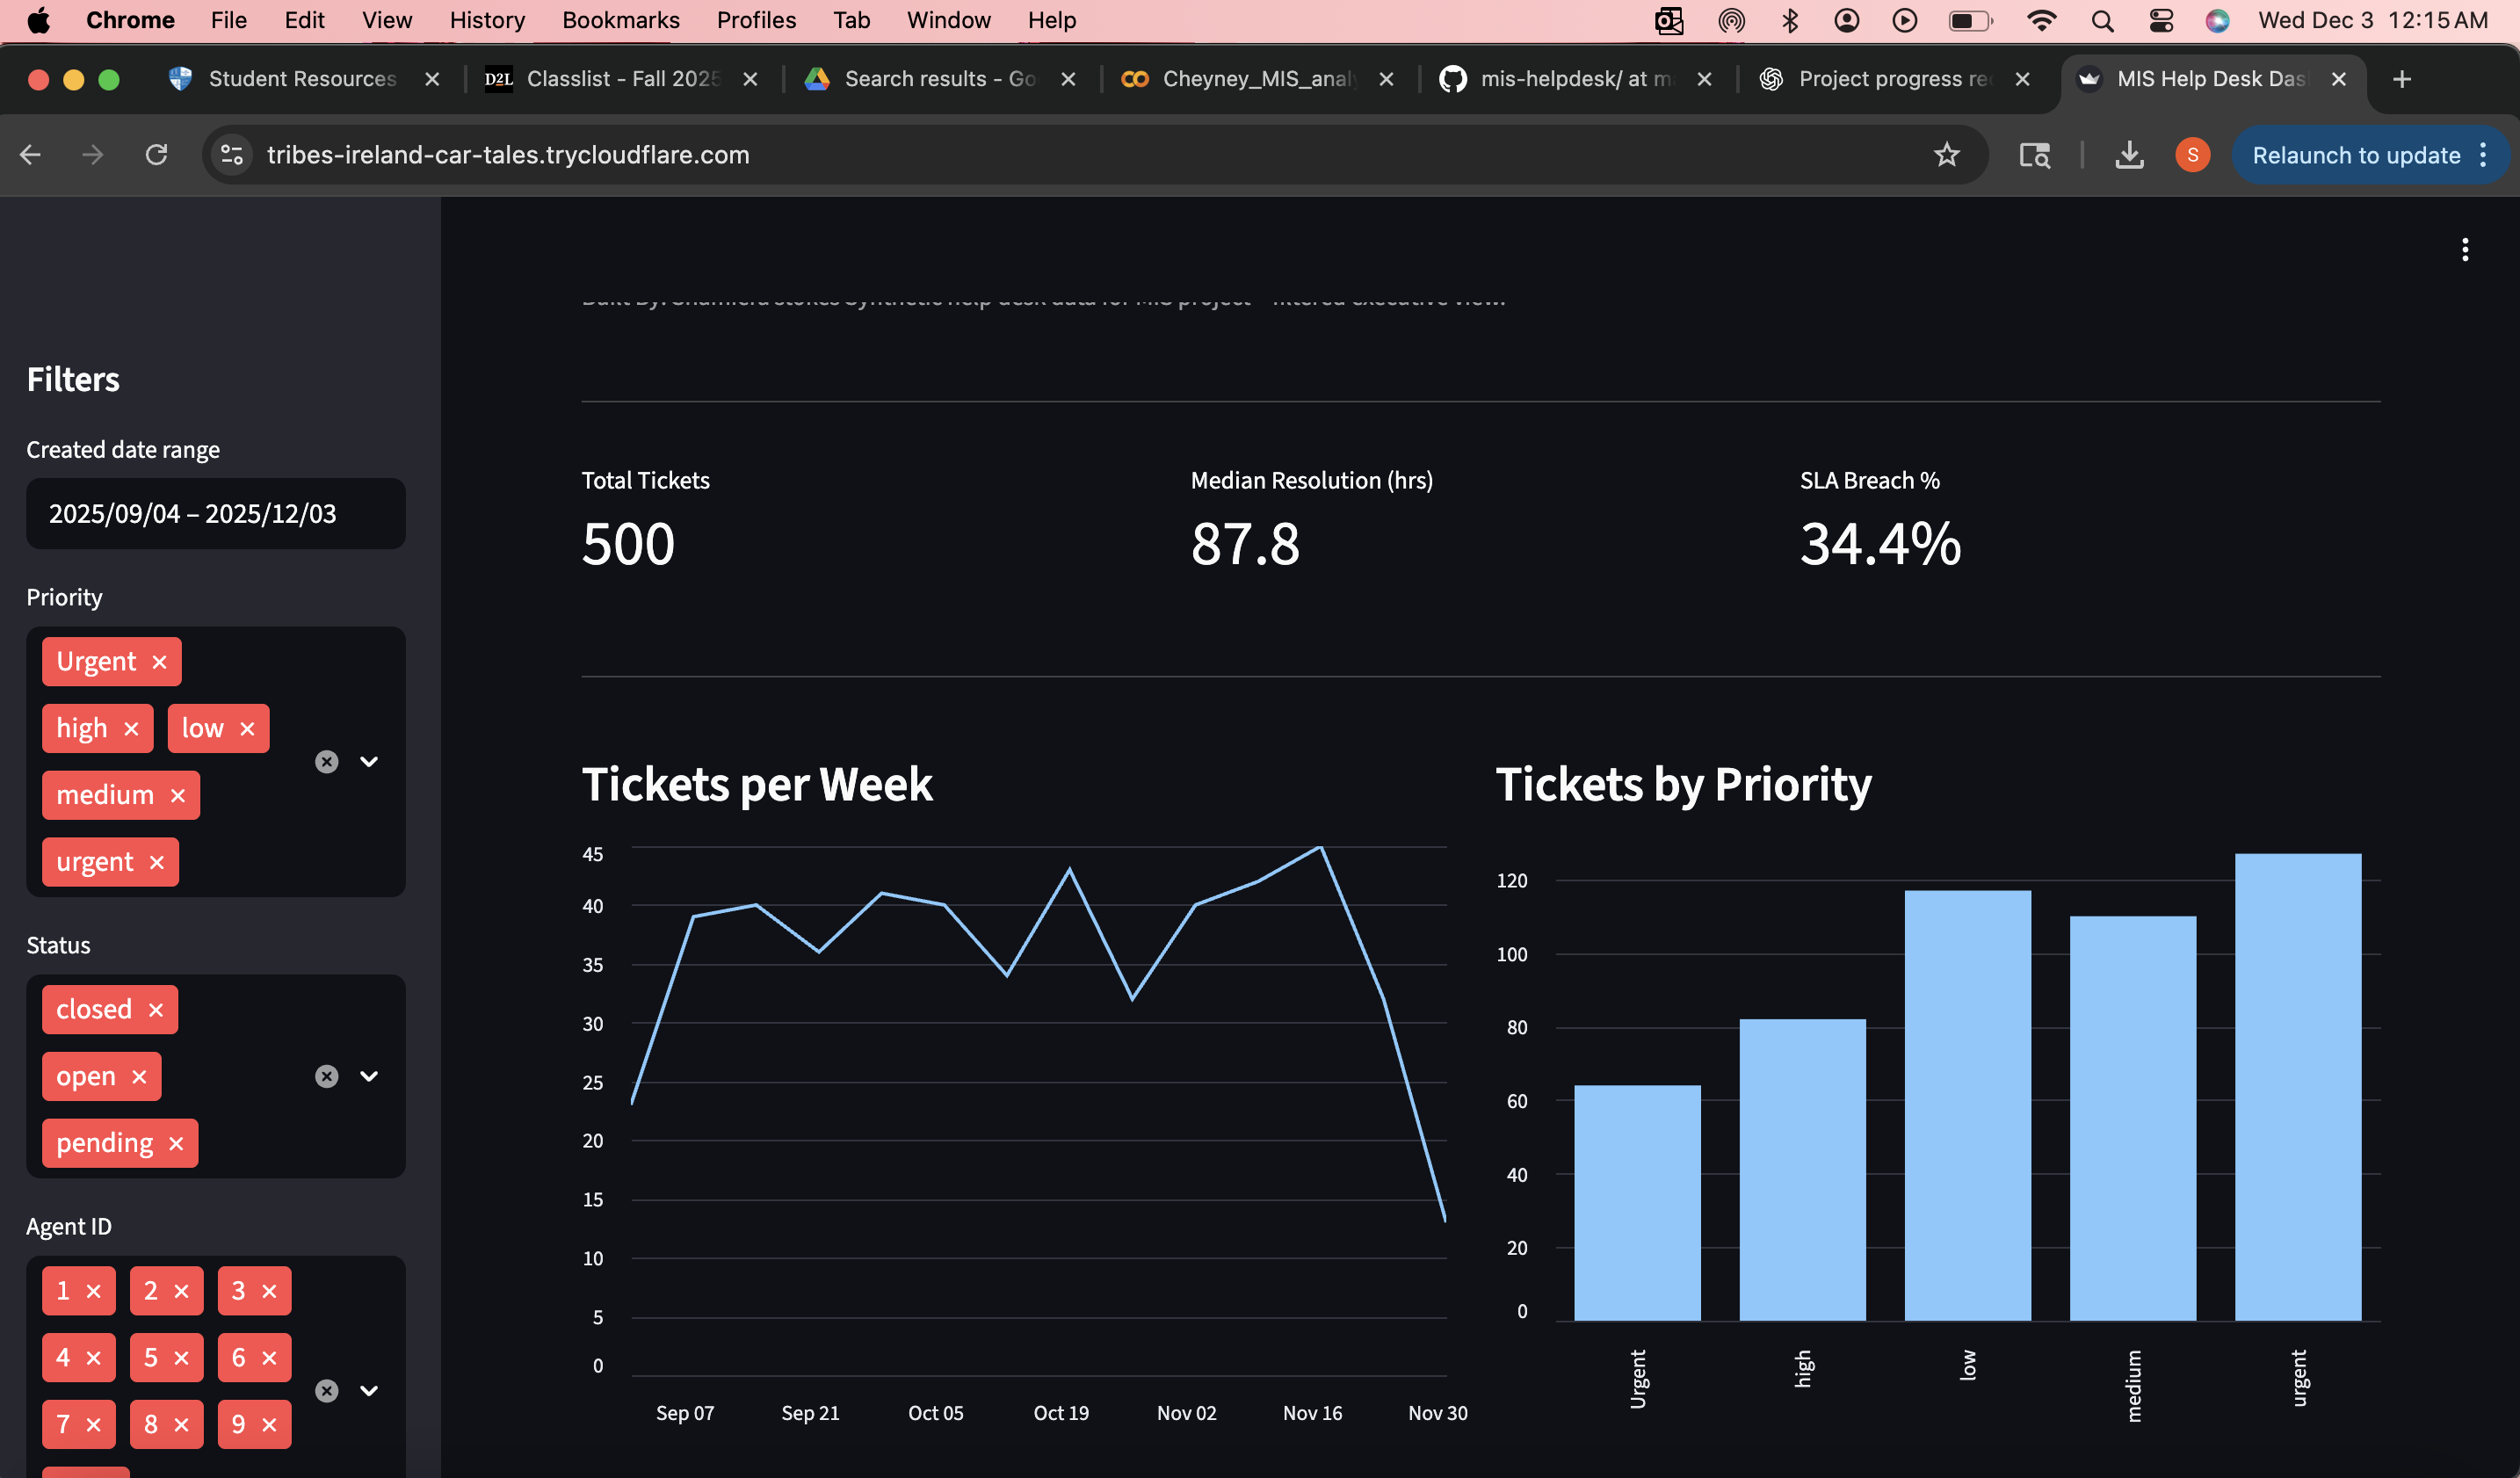

*